In [1]:
import theano
import numpy as np
import sys

%matplotlib inline
import matplotlib.pyplot as plt

In this notebook we would like to provide a quick tutorial for the code discussed in:

Riesselman, A.J.+, Ingraham, J.B.+, and Marks, D.S., 2017. Deep generative models of genetic variation capture mutation effects. arXiv preprint arXiv:1712.06527.

We will walk through the basic functions of loading up a model, predicting the effects of mutations, and obtaining the latent variables for sequences in the dataset. Since model training is computationally expensive and is best suited for a GPU-enabled compute cluster, executables for the SVI and MLE version of the code are available.

# Loading the model

In [2]:
sys.path.insert(0, "../DeepSequence")

import model
import helper
import train

First let's load up a model. We don't have to calculate sequence weights here because we are not training a model and this can be slow on the CPU. 

In [3]:
data_params = {"dataset":"BLAT_ECOLX"}

data_helper = helper.DataHelper(
                dataset=data_params["dataset"],
                working_dir=".",
                calc_weights=False
                )

model_params = {
        "batch_size"        :   100,
        "encode_dim_zero"   :   1500,
        "encode_dim_one"    :   1500,
        "decode_dim_zero"   :   100,
        "decode_dim_one"    :   500,
        "n_patterns"        :   4,
        "n_latent"          :   2,
        "logit_p"           :   0.001,
        "sparsity"          :   "logit",
        "encode_nonlin"     :   "relu",
        "decode_nonlin"     :   "relu",
        "final_decode_nonlin":  "sigmoid",
        "output_bias"       :   True,
        "final_pwm_scale"   :   True,
        "conv_pat"          :   True,
        "d_c_size"          :   40
        }

vae_model   = model.VariationalAutoencoder(data_helper,
    batch_size              =   model_params["batch_size"],
    encoder_architecture    =   [model_params["encode_dim_zero"],
                                model_params["encode_dim_one"]],
    decoder_architecture    =   [model_params["decode_dim_zero"],
                                model_params["decode_dim_one"]],
    n_latent                =   model_params["n_latent"],
    n_patterns              =   model_params["n_patterns"],
    convolve_patterns       =   model_params["conv_pat"],
    conv_decoder_size       =   model_params["d_c_size"],
    logit_p                 =   model_params["logit_p"],
    sparsity                =   model_params["sparsity"],
    encode_nonlinearity_type       =   model_params["encode_nonlin"],
    decode_nonlinearity_type       =   model_params["decode_nonlin"],
    final_decode_nonlinearity      =   model_params["final_decode_nonlin"],
    output_bias             =   model_params["output_bias"],
    final_pwm_scale         =   model_params["final_pwm_scale"],
    working_dir             =   ".")

print ("Model built")

Encoding sequences
Neff = 8355.0
Data Shape = (8355, 253, 20)
Model built


Load up the parameters of a pretrained model in the 'params' folder.

In [4]:
file_prefix = "vae_output_encoder-1500-1500_Nlatent-30_decoder-100-500_dataset-amp_2500_log_fix-_theta-0.2_batch_s-100_conv_pat-True_d_c_size-40_fdn-sigmoid_fps-True_logit_p-0.001_n_pat-4_o_bias-True_r_seed-5_sparsity-logit_wu-0.0"

vae_model.load_parameters(file_prefix=file_prefix)

print ("Parameters loaded")

Parameters loaded


Print the name, location, and sequence of the focus sequence of the alignment:

In [5]:
print (data_helper.focus_seq_name)
print (str(data_helper.focus_start_loc)+"-"+str(data_helper.focus_stop_loc))
print (data_helper.focus_seq)

>BLAT_ECOLX/24-286
24-286
hpetlVKVKDAEDQLGARVGYIELDLNSGKILeSFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGErGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIkhw


However, we remove lowercase letters from the focus sequences before training because columns of the alignment in those positions have little amino acid coverage in them:

In [6]:
print ("".join(data_helper.focus_seq_trimmed))

VKVKDAEDQLGARVGYIELDLNSGKILSFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGEGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLI


# Model functions

Let's get the latent variables for that sequence of the model. This model has a 30 dimensional latent representation whose prior is a diagonal Gaussian.

In [7]:
focus_seq_one_hot = np.expand_dims(data_helper.one_hot_3D(data_helper.focus_seq_trimmed),axis=0)
mu_blat, log_sigma_blat = vae_model.recognize(focus_seq_one_hot)
print ("mu:")
print (mu_blat[0])
print ("\nlog sigma:")
print (log_sigma_blat[0])

mu:
[-0.0467364  -0.00876267 -0.01259878 -0.02465395  0.01402996  0.01595688
  0.06496335  0.00301787  0.02905439 -1.49900055 -0.23235589  0.27315212
  0.00694647 -0.01243441 -0.00626889 -0.15998059 -0.04428625 -1.06948749
  2.45640981  0.04433935  0.06063476  0.01699242  0.02461767 -0.04132388
  0.04005286  0.05231199 -0.00557423  0.02440171 -0.01919557 -1.30247023]

log sigma:
[ 0.02269554  0.01490107  0.0242448   0.02028344  0.01610491  0.02284766
  0.06471057  0.04549785 -0.00498715 -1.96205697 -1.96771655 -2.1558796
  0.03802201  0.05420063  0.02202471 -0.20421001  0.03626581 -2.1786715
 -2.15794638  0.00914391  0.0096762   0.00272555  0.04566289  0.03119208
  0.02526869  0.01392488  0.03607735  0.06530051  0.03895306 -2.32025426]


We can also sample from this model:

In [8]:
z_blat = vae_model.encode(focus_seq_one_hot)
print ("z:")
print (z_blat[0])

z:
[ 1.23824058 -0.55476865 -0.11949985  0.65899501 -0.70560614  1.03498715
  0.14228214 -0.69302503  0.96147019 -1.51885075 -0.12075319  0.3030073
  1.37965293  1.2016533  -0.10541721 -0.5787318   0.59332843 -1.07115399
  2.22658665  1.27131978 -0.73471772  0.21237746  0.58999158 -0.40737377
 -0.55413066  1.87899219  0.71873826 -1.47029659 -0.14475472 -1.19356352]


And then generate a sample distribution around that sequence via the sampled latent variable. The "reorder_alphabet" label is the amino acid alphabet roughly reordered by biochemical properties.

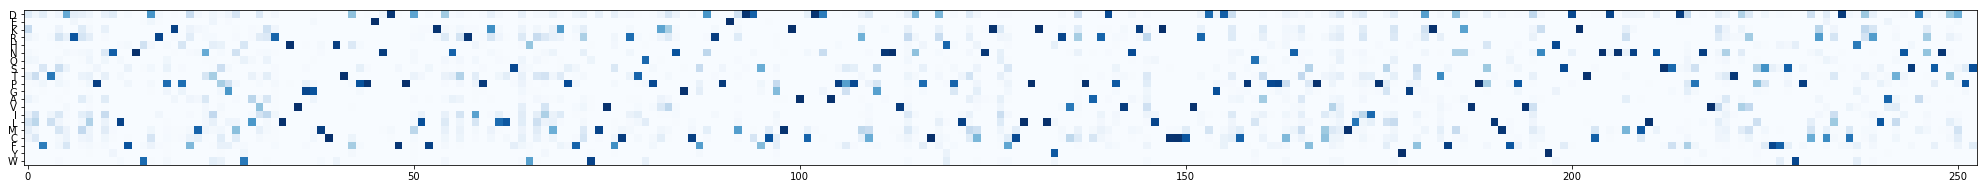

In [17]:
seq_reconstruct = vae_model.decode(z_blat)
plt.figure(figsize=(35,10))
plt.imshow(seq_reconstruct[0].T,cmap=plt.get_cmap("Blues"))
ax = plt.gca()
ax.set_yticks(np.arange(len(data_helper.reorder_alphabet)))
ax.set_yticklabels(list(data_helper.reorder_alphabet))
plt.show()

# Mutation effect prediction

Mutation effect prediction helper functions are always with respect to the focus sequence of the alignment. We can ask for a prediction of mutation effect individually.

For reliable mutation effect prediction results, we recommend taking 500-2000 samples from the model (with the N_pred_iterations parameter).

We can predict the effects of single, double, triple mutants, etc. Mutations are organized as a list of tuples, where the tuples are (uniprot position, wt amino acid, mutant amino acid).

In [10]:
print (data_helper.delta_elbo(vae_model,[(182,"M","T")], N_pred_iterations=50))

-10.6103577992


In [11]:
print (data_helper.delta_elbo(vae_model,[(182,"M","T"), (42,"A","G")], N_pred_iterations=50))

-17.0729389925


In [12]:
print (data_helper.delta_elbo(vae_model,[(182,"M","T"), (42,"A","G"), (104,"E","K")], N_pred_iterations=50))

-23.3313822241


We can predict the effects of mutations for all single mutations. This and the below function are preferred because they can take advantages of speed-ups from minibatching the mutation data.

In [13]:
mutant_name_list, delta_elbos = data_helper.single_mutant_matrix(vae_model, N_pred_iterations=50)

In [14]:
print (mutant_name_list[0], delta_elbos[0])

('V29A', 1.9106364979227521)


We can also predict the effect of mutations from a file in batched mode.

In [15]:
mutant_name_list, delta_elbos = data_helper.custom_mutant_matrix("mutations/BLAT_ECOLX_Ranganathan2015_BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105_vae_results.csv",\
                                                                 vae_model, N_pred_iterations=50)

In [16]:
print (mutant_name_list[12], delta_elbos[12])

('V29Q', 4.534719118091829)
